In [38]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
# from IPython.display import HTML
import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt
import os

from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau

import tensorflow as tf
from tensorflow.keras import models, layers
# import matplotlib.pyplot as plt
# from IPython.display import HTML
import pandas as pd
import numpy as np
import os
import pickle
import PIL
from PIL import Image

from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import RMSprop

Here i will try to assemble the important stuff and try to make it look more like a proper pipeline/project. Will train the most promising model on the complete dataset and also use both the 'red filter' together wtith the data augmentation for the minority class.

First lets look for tomato pictures that have the acutal tomatoe in them and not just the leaf

In [5]:
import os
from PIL import Image

folder_path = "C:/Users/Magnus/Desktop/code/timeSeries/TOMATOE_HEALTHY/Tomato_healthy"

file_names = []
for file_name in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file_name)
    image = Image.open(file_path)
    red_channel = image.split()[0]  # Get the red channel

    red_values = list(red_channel.getdata())  # Get all red values in the image

    red_average = sum(red_values) / len(red_values)
    if red_average > 140:
        file_names.append(file_name)

# print(file_names)

for i in file_names:
    print(i)

#* 2 results. One of them turned out to be a false positive and the other one i removed from the healthy tomato class
#* I used the file name and searched for the image in windows

377ffc94-d068-4ba0-80cc-dea49edf094d___RS_HL 0367.JPG
7de93009-6180-4027-8779-76947cda3e2f___2700323949_95aa2eaa01_o.jpg


Then let us add some alterations of the minority class 'mosaic_virus' to the full tomato dataset. The reason is that i want to balance out the data a bit more.

In [6]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomContrast(0.2),
  tf.keras.layers.RandomBrightness(0.2)
])

folder_path = r"C:\Users\Magnus\Desktop\code\timeSeries\mosaic_virus"

# the minority class
mosaic_virus = tf.keras.preprocessing.image_dataset_from_directory(
    'mosaic_virus',
    seed=12345,
    shuffle=False
)

# I run it twice so that i double i get a total of triple the amount of images.
mosaic_virus_aug_1 = mosaic_virus.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

mosaic_virus_aug_2 = mosaic_virus.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)


# Create a directory to save the images
save_dir = 'augmented_images'
os.makedirs(save_dir, exist_ok=True)

Found 373 files belonging to 1 classes.


In [7]:
# Initialize a counter
counter = 0
# Iterate over the dataset and save each image
for batch_images, batch_labels in mosaic_virus_aug_1:
    for image, label in zip(batch_images, batch_labels):
        # Convert the image tensor to a PIL image
        image_pil = PIL.Image.fromarray(image.numpy().astype(np.uint8))
        # Generate a unique filename based on the label and counter
        filename = f'label_{label.numpy()}_{counter}.jpg'
        # Save the image to the save directory
        image_pil.save(os.path.join(save_dir, filename))

        # Increment the counter
        counter += 1

for batch_images, batch_labels in mosaic_virus_aug_2:
    for image, label in zip(batch_images, batch_labels):
        # Convert the image tensor to a PIL image
        image_pil = PIL.Image.fromarray(image.numpy().astype(np.uint8))
        # Generate a unique filename based on the label and counter
        filename = f'label_{label.numpy()}_{counter}.jpg'
        # Save the image to the save directory
        image_pil.save(os.path.join(save_dir, filename))

        # Increment the counter
        counter += 1

The full tomatoe dataset contains 10 classes that now has 16756 images (including the augmented images)

In [2]:
# load my dataset
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3


dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'TomatoeVillage',
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)
class_names = dataset.class_names
n_classes = len(class_names)

Found 16756 files belonging to 10 classes.


Splitting the data the same way as is done with sklearn's train_test_split

In [3]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [4]:
rescale = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
])
train_ds = train_ds.map(
    lambda x, y: (rescale(x, training=True), y)
)

val_ds = val_ds.map(
    lambda x, y: (rescale(x, training=True), y)
)

test_ds = test_ds.map(
    lambda x, y: (rescale(x, training=True), y)
)

I only realized at the end that i had some data leakage from when i used image_dataset_from_directory() again after restarting my pc. Another issue with tf.dataset is how it seems to not be easy to store (takes up alot more storage than the original dataset). There is probable some other convention when it comes to storing tf.dataset that I am currently unaware of.

In [17]:
tf.data.experimental.save(val_ds, "C:\\Users\\Magnus\\Desktop\\code\\timeSeries\\tf_df")
loaded_ds = tf.data.Dataset.load("C:\\Users\\Magnus\\Desktop\\code\\timeSeries\\tf_df")

for i,j in loaded_ds:
    print(i.shape)
    print(j)
    break

I have to create all the paths and folders for the model and its metrics to be saved in. 

In [5]:
model_name = 'final_model'
folder_name = f'my_models/{model_name}'
os.makedirs(f'my_models/{model_name}', exist_ok=True)
folder_path = os.path.abspath(folder_name)
checkpoint_path = os.path.join(folder_path, "checkpoint")
os.makedirs(checkpoint_path , exist_ok=True)
plot_path = os.path.join(folder_path, "plots")
os.makedirs(plot_path , exist_ok=True)

I decided to change the optimizer from RMSprop to Adam since it converges a bit faster and i dont have the resources to train for lots of eochs.

In [8]:
modelcheckpoint  = ModelCheckpoint(filepath=checkpoint_path,save_best_only=True, monitor="val_loss")

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001)

callback_list  = [modelcheckpoint, reduce_lr]


model = keras.Sequential([
    layers.Input(shape=(256, 256, 3), name='Input'),
    layers.Conv2D(filters=32, kernel_size=3, activation="relu", name='conv_layer1'),
    layers.MaxPooling2D(pool_size=2, name='pooling1'),
    layers.Conv2D(filters=64, kernel_size=3, activation="relu", name='conv_layer2'),
    layers.MaxPooling2D(pool_size=2, name='pooling2'),
    layers.Conv2D(filters=128, kernel_size=3, activation="relu", name='conv_layer3'),
    layers.MaxPooling2D(pool_size=2, name='pooling3'),
    layers.Conv2D(filters=256, kernel_size=3, activation="relu", name='conv_layer4'),
    layers.MaxPooling2D(pool_size=2, name='pooling4'),
    layers.BatchNormalization(name='batching1'),
    layers.Conv2D(filters=256, kernel_size=3, activation="relu", name='conv_layer5'),
    layers.MaxPooling2D(pool_size=2, name='pooling5'),
    layers.Dropout(0.20),
    layers.Conv2D(filters=384, kernel_size=3, activation="relu", name='conv_layer6'),
    layers.MaxPooling2D(pool_size=2, name='pooling6'),
    layers.Dropout(0.20),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.20),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.20),
    layers.Dense(10, activation="softmax", name='output')
], name= model_name)

model.compile(optimizer='adam', loss='SparseCategoricalCrossentropy', metrics=['accuracy'])

# history = model.fit(train_ds, validation_data=val_ds, epochs=3, callbacks=callback_list)

In [22]:
model.summary()

Model: "final_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_layer1 (Conv2D)        (None, 254, 254, 32)      896       
                                                                 
 pooling1 (MaxPooling2D)     (None, 127, 127, 32)      0         
                                                                 
 conv_layer2 (Conv2D)        (None, 125, 125, 64)      18496     
                                                                 
 pooling2 (MaxPooling2D)     (None, 62, 62, 64)        0         
                                                                 
 conv_layer3 (Conv2D)        (None, 60, 60, 128)       73856     
                                                                 
 pooling3 (MaxPooling2D)     (None, 30, 30, 128)       0         
                                                                 
 conv_layer4 (Conv2D)        (None, 28, 28, 256)       

So the idea here is that i run the cell below once. The cell trains the models and creates the the metrics and store them in the model folder. When you want to train the model more then run the cell after this which load the model and continues the trainings and updates all the metrics and graphs.

In [ ]:
epochs = 5
# i use the validation set and a couple of callbacks
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callback_list)

#* Saves the loss and accuracy scores for each epoch. I convert it to a dataFrame
history_metrics = pd.DataFrame(history.history)

#* I run evaluate on the test set (bad practice) and save and format the accuracy score.
evaluation_scores = model.evaluate(test_ds)
print(f"Loss = {evaluation_scores[0]}")
acc = evaluation_scores[1]
formatted_acc = "{:.1%}".format(acc)
print(f"Accuracy = {formatted_acc}")

#* Save accuracy in a dictionary
accuracy_dict = {}
epoch = len(history_metrics)
accuracy_dict[f'Epoch {epoch}'] = acc

#* Create model version list. Will be incrmented each time we train the model.
model_version_list = [1]

plt.clf()
#* make a plot of accuracy for validation set for each epoch and stamp on the final test set accuracy
history_metrics[['accuracy','val_accuracy']].plot()

plt.text(0.5, 0.5, f'{formatted_acc} Accuracy on test_ds', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='red', alpha=0.2))
# plt.savefig(plot_path + str(model_version_list[0]))
plt.savefig(plot_path + "/" + str(model_version_list[0]))
plt.show()

#* Now we save the model, model_version, accuracy_dict, history_metrics, and model_version on the harddrive using pickle
with open(folder_path + '/history_metrics.pickle', 'wb') as f:
    pickle.dump(history_metrics, f)

with open(folder_path + '/accuracy_dict.pickle', 'wb') as f:
    pickle.dump(accuracy_dict, f)
    
with open(folder_path + '/model_version.pickle', 'wb') as f:
    pickle.dump(model_version_list, f)
    
model.save(f'{folder_path}/{max(model_version_list)}')

This Cell is the one you should re-run each time you want to train the model more.

Epoch 1/10
419/419 [==============================] - 779s 2s/step - loss: 0.2416 - accuracy: 0.9247 - val_loss: 0.4084 - val_accuracy: 0.8714
Epoch 2/10
419/419 [==============================] - 775s 2s/step - loss: 0.2038 - accuracy: 0.9345 - val_loss: 0.1727 - val_accuracy: 0.9377
Epoch 3/10
419/419 [==============================] - 758s 2s/step - loss: 0.1768 - accuracy: 0.9426 - val_loss: 0.1789 - val_accuracy: 0.9381
Epoch 4/10
419/419 [==============================] - 868s 2s/step - loss: 0.1846 - accuracy: 0.9404 - val_loss: 1.5608 - val_accuracy: 0.7109
Epoch 5/10
419/419 [==============================] - 959s 2s/step - loss: 0.1611 - accuracy: 0.9482 - val_loss: 0.1580 - val_accuracy: 0.9429
Epoch 6/10
419/419 [==============================] - 790s 2s/step - loss: 0.1467 - accuracy: 0.9523 - val_loss: 0.3243 - val_accuracy: 0.8966
Epoch 7/10
419/419 [==============================] - 750s 2s/step - loss: 0.1598 - accuracy: 0.9507 - val_loss: 0.2471 - val_accuracy: 0.9135

INFO:tensorflow:Assets written to: c:\Users\Magnus\Desktop\code\timeSeries\my_models\final_model/5\assets


<Figure size 640x480 with 0 Axes>

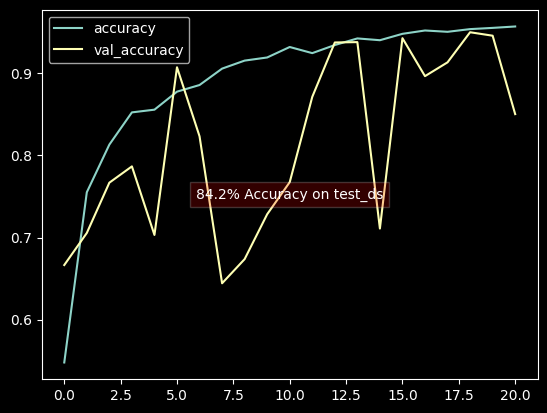

final_model 5 has finished training!


In [13]:
# Load the pickled DataFrame
with open(folder_path + '\history_metrics.pickle', 'rb') as f:
    past_history  = pickle.load(f)

# Load the pickled DataFrame
with open(folder_path + '\\accuracy_dict.pickle', 'rb') as f:
    accuracy_dict = pickle.load(f)
    
# Load the model version list
with open(folder_path + '\model_version.pickle', 'rb') as f:
    model_version_list = pickle.load(f)

# Load the current model version number  
model_version = max(model_version_list)

# Use the current version model number for loading the latest model
model = tf.keras.models.load_model(folder_path + "/" + str(model_version))


#! set the amount of epochs you want to train this session
epochs = 10

#! Somehow i forgot to define and add the callbacks!
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

# Again load the metrics into a dataFrame
history_metrics = pd.DataFrame(history.history)

# Again calculate the accuracy and format it so it can be plotted
evaluation_scores = model.evaluate(test_ds)
print(f"Loss = {evaluation_scores[0]}")
acc = evaluation_scores[1]
formatted_acc = "{:.1%}".format(acc)
print(f"Accuracy = {formatted_acc}")


# Combine old and new history dataFrames so that i can keep track of the model metrics in one dataFrame
history_concat = pd.concat([past_history, history_metrics], ignore_index=True)
total_epochs = len(history_concat)
accuracy_dict[f'Epoch {total_epochs}'] = acc

# Iterate model version number so i can save new model version after training
new_model_version = model_version + 1
model_version_list.append(new_model_version)


# Save all the new updated, history_metrics, accuracy_dict, model_version, and model
with open(folder_path + '/history_metrics.pickle', 'wb') as f:
    pickle.dump(history_concat, f)

with open(folder_path + '/accuracy_dict.pickle', 'wb') as f:
    pickle.dump(accuracy_dict, f)
    
with open(folder_path + '/model_version.pickle', 'wb') as f:
    pickle.dump(model_version_list, f)

model.save(f'{folder_path}/{max(model_version_list)}')


plt.clf()
# make a plot of accuracy for validation set for each epoch and stamp on the final test set accuracy
history_concat[['accuracy','val_accuracy']].plot()
plt.text(0.5, 0.5, f'{formatted_acc} Accuracy on test_ds', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='red', alpha=0.2))
# save the new plot
plt.savefig(plot_path + "/" + str(new_model_version))
plt.show()

print(f"{model_name} {new_model_version} has finished training!")

Here is a brief overview of hte model metrics:

In [24]:
with open(folder_path + '\\accuracy_dict.pickle', 'rb') as f:
    accuracy_dict = pickle.load(f)
accuracy_dict

{'Epoch 3': 0.7553443908691406,
 'Epoch 4': 0.7700471878051758,
 'Epoch 6': 0.9091981053352356,
 'Epoch 11': 0.7665094137191772,
 'Epoch 21': 0.8419811129570007}

In [25]:
with open(folder_path + '\history_metrics.pickle', 'rb') as f:
    past_history  = pickle.load(f)
past_history
#! since i forgot the callback , the learning rate did not get adjusted by the ReduceLROnPlateau
#! Since i forgot to include the callback the checkpoint did not store either! save_best = True would have saved epoch 18

#? Still think that the model is underfitted adn the the true accuracy is around 96-98%

,loss,accuracy,val_loss,val_accuracy,lr
0,1.337298,0.547733,1.360618,0.666466,0.001
1,0.728466,0.755151,1.008013,0.705529,0.001
2,0.553712,0.813228,0.693876,0.766827,0.001
3,0.448092,0.852476,0.601899,0.786659,NaN
4,0.429644,0.855778,1.078586,0.703125,NaN
5,0.371572,0.877725,0.271992,0.907452,NaN
6,0.361631,0.885814,0.499952,0.823317,NaN
7,0.284474,0.905802,2.464110,0.644231,NaN
8,0.249413,0.915572,1.597094,0.673678,NaN
9,0.240702,0.919379,0.864731,0.728365,NaN


lets make some predictions on the 'final' model. 

In [ ]:
model_name = 'final_model'
folder_name = f'my_models/{model_name}'
os.makedirs(f'my_models/{model_name}', exist_ok=True)
folder_path = os.path.abspath(folder_name)
checkpoint_path = os.path.join(folder_path, "checkpoint")
os.makedirs(checkpoint_path , exist_ok=True)
plot_path = os.path.join(folder_path, "plots")
os.makedirs(plot_path , exist_ok=True)

model = tf.keras.models.load_model(folder_path + "/" + str(model_version))

1/1 [==============================] - 0s 44ms/step


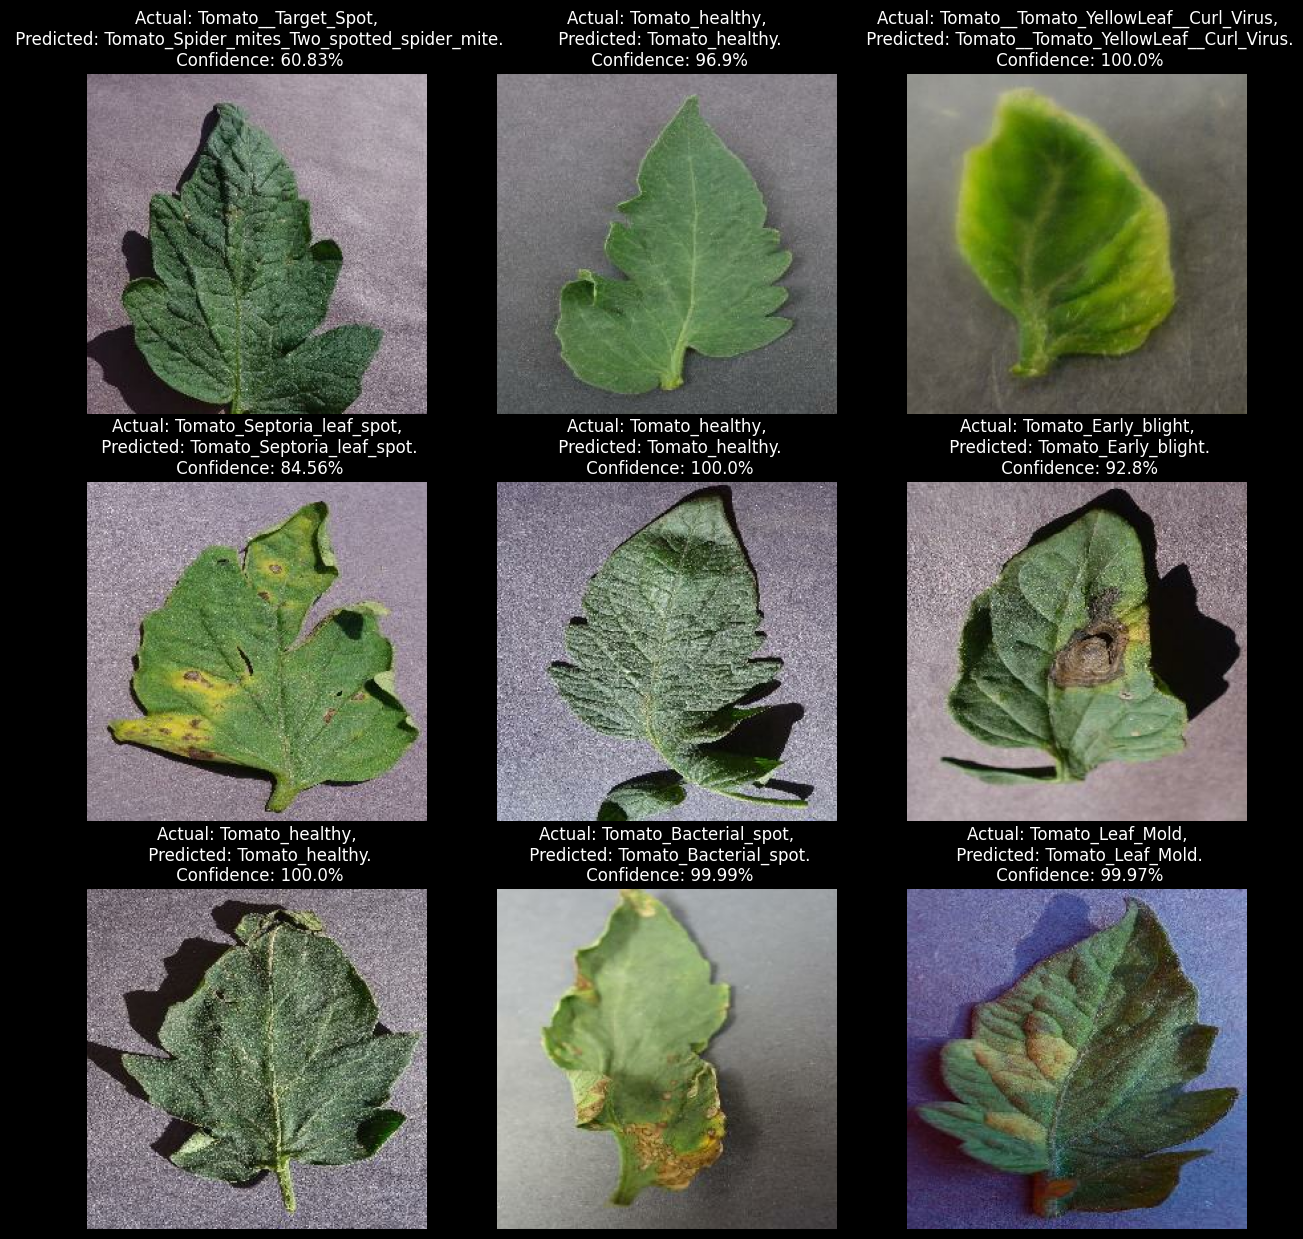

In [43]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        image = images[i].numpy()  # Get the image data as a NumPy array
        image = (image * 255).astype("uint8")  # Scale to [0, 255] and convert to uint8
        plt.imshow(image)
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
# This is just s small sample. This time we got 8 of 9 correct. It is encoraging that the one that the model got wrong it was teh least sure about!